<center><h3><u><b>Recommendation Systems Project</b></u></h3></center>

<b><h4><u>Domain:</u></h4></b> E-commerce 

<h4><b><u>Data Description:</u></b></h4>
Amazon Reviews data (data source) The repository has several datasets. For this
case study, we are using the Electronics dataset.
</p>

<h4><b><u>Context:</u></b></h4>
<p>Online E-commerce websites like Amazon, Flipkart uses different
recommendation models to provide different suggestions to different users.
Amazon currently uses item-to-item collaborative filtering, which scales to
massive data sets and produces high-quality recommendations in real-time.
</p>
<h4><b><u>Attribute Information:</u></b></h4>
<ul>
  <li>userId &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; : Every user identified with a unique id</li>
  <li>productId &nbsp;&nbsp;&nbsp;: Every product identified with a unique id</li>
  <li>Rating &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: Rating of the corresponding product by the corresponding
user</li>
  <li>timestamp &nbsp;: Time of the rating ( ignore this column for this exercise)</li>
</ul>

**Importing necessarylibraries**

In [1]:
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import scipy.sparse
from scipy.sparse import csr_matrix
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
dataset_path = "/content/drive/My Drive/GreatLearning/Recommendation Systems/ratings_Electronics.csv"

In [3]:
product_dataset = pd.read_csv(dataset_path, header=None)
product_dataset.columns = ['UserID', 'ProductID', 'ProductRating', 'Timestamp']
product_dataset = product_dataset.iloc[:, :-1]
product_dataset.head()

,UserID,ProductID,ProductRating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [4]:
product_dataset.dtypes

UserID            object
ProductID         object
ProductRating    float64
dtype: object

In [5]:
product_dataset.shape

(7824482, 3)

In [6]:
null_val_df = pd.DataFrame(product_dataset.isnull().sum().index, columns=["Column"])
null_val_df["Null Count"] = list(product_dataset.isnull().sum())
null_val_df["Is Null"] = list(product_dataset.isnull().any())
null_val_df

,Column,Null Count,Is Null
0,UserID,0,False
1,ProductID,0,False
2,ProductRating,0,False


<b><h4><u>Observation:</u></h4></b>
<p>There are no missing values</p>

In [7]:
product_dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
ProductRating,7824482.0,4.012337,1.38091,1.0,3.0,5.0,5.0,5.0


**Finding out unique values in product rating**

In [8]:
product_dataset.ProductRating.unique()

array([5., 1., 3., 2., 4.])

**Finding out unique values in product id**

In [9]:
product_dataset.ProductID.unique()

array(['0132793040', '0321732944', '0439886341', ..., 'BT008T2BGK',
       'BT008UKTMW', 'BT008V9J9U'], dtype=object)

**Finding out unique values in UserID**

In [10]:
product_dataset.UserID.unique()

array(['AKM1MP6P0OYPR', 'A2CX7LUOHB2NDG', 'A2NWSAGRHCP8N5', ...,
       'A180UGKKYCPDH0', 'A2IGIIABRZ5LAB', 'A10M2KEFPEQDHN'], dtype=object)

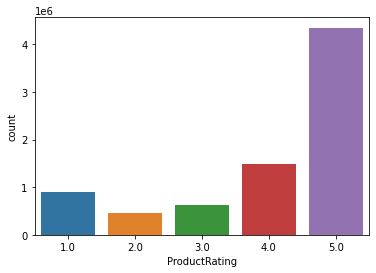

In [11]:
sns.countplot(data=product_dataset , x='ProductRating')

<h4><b><u>Observation:</u></b></h4>
<p>We can see that there are many product whose raiting is 5.0</p>

**For more accurate results only consider users who have rated atleast 50 or more Product**

In [12]:
user_counts = product_dataset.UserID.value_counts()
new_product_dataset = product_dataset[product_dataset['UserID'].isin(user_counts[user_counts >= 50].index)]
new_product_dataset.head(10)

,UserID,ProductID,ProductRating
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0
631,A3TAS1AG6FMBQW,0972683275,5.0
1003,A2Y4H3PXB07WQI,0972683275,4.0
1138,A25RTRAPQAJBDJ,0972683275,5.0
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0


In [13]:
new_product_dataset.shape

(125871, 3)

**Count Plot for new dataset**

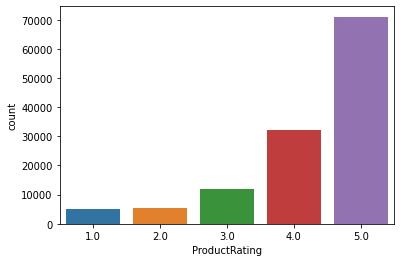

In [14]:
sns.countplot(data=new_product_dataset , x='ProductRating')

#### **Building Popularity Recommender model**

In [15]:
new_product_dataset_mean_df = pd.DataFrame(list(new_product_dataset.groupby('ProductID')['ProductRating'].mean().head().index), columns=["ProductID"])
new_product_dataset_mean_df["MeanRating"] = list(new_product_dataset.groupby('ProductID')['ProductRating'].mean().head().values)
new_product_dataset_mean_df

,ProductID,MeanRating
0,0594451647,5.000000
1,0594481813,3.000000
2,0970407998,2.500000
3,0972683275,4.750000
4,1400501466,3.333333


In [16]:
new_product_dataset_mean_s_df = pd.DataFrame(list(new_product_dataset.groupby('ProductID')['ProductRating'].mean().sort_values(ascending=False).head().index), columns=["ProductID"])
new_product_dataset_mean_s_df["MeanRating"] = list(new_product_dataset.groupby('ProductID')['ProductRating'].mean().sort_values(ascending=False).head().values)
new_product_dataset_mean_s_df

,ProductID,MeanRating
0,B00LKG1MC8,5.0
1,B002QUZM3M,5.0
2,B002QWNZHU,5.0
3,B002QXZPFE,5.0
4,B002R0DWNS,5.0


In [17]:
new_product_dataset_mean_c_df = pd.DataFrame(list(new_product_dataset.groupby('ProductID')['ProductRating'].count().sort_values(ascending=False).head(5).index), columns=["ProductID"])
new_product_dataset_mean_c_df["RatingCount"] = list(new_product_dataset.groupby('ProductID')['ProductRating'].count().sort_values(ascending=False).head(5).values)
new_product_dataset_mean_c_df

,ProductID,RatingCount
0,B0088CJT4U,206
1,B003ES5ZUU,184
2,B000N99BBC,167
3,B007WTAJTO,164
4,B00829TIEK,149


In [18]:
print("***********************************************")
print("* Recommending Most Raited (Popular) Products *")
print("***********************************************\n")
ratings_mean_count = pd.DataFrame(list(new_product_dataset.groupby('ProductID')['ProductRating'].mean().index), columns=["ProductID"]) 
ratings_mean_count["AvgRating"] = list(new_product_dataset.groupby('ProductID')['ProductRating'].mean().values)
ratings_mean_count["RatingCounts"] = list(new_product_dataset.groupby('ProductID')['ProductRating'].count().values)
ratings_mean_count = ratings_mean_count[(ratings_mean_count["AvgRating"] >= 4) & (ratings_mean_count["RatingCounts"] >= 100)]
ratings_mean_count.sort_values(by=['RatingCounts'], ascending=False).head(10)

***********************************************
* Recommending Most Raited (Popular) Products *
***********************************************



,ProductID,AvgRating,RatingCounts
39003,B0088CJT4U,4.218447,206
24827,B003ES5ZUU,4.864130,184
11078,B000N99BBC,4.772455,167
38250,B007WTAJTO,4.701220,164
38615,B00829TIEK,4.436242,149
38611,B00829THK0,4.416058,137
39338,B008DWCRQW,4.094891,137
21982,B002R5AM7C,4.125000,128
28761,B004CLYEDC,4.669492,118
22210,B002SZEOLG,4.247788,113


**Intalling surprise library**

In [19]:
!pip install surprise

#### **Collaborative Filtering Based Recommendation Systems**

In [20]:
from surprise import Dataset,Reader
from surprise.model_selection import cross_validate, train_test_split
from surprise import NormalPredictor
from surprise import SVD, KNNWithMeans
from surprise import accuracy

In [21]:
surprise_rating_reader = Reader(rating_scale=(1, 5))
products_data = Dataset.load_from_df(new_product_dataset, surprise_rating_reader)
products_data.df.head()

,UserID,ProductID,ProductRating
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0


In [22]:
trainset, testset = train_test_split(products_data, test_size=.30,random_state=42)
trainset.n_ratings, trainset.n_users, trainset.n_items

(88109, 1540, 38173)

**SVD Based Recommendation System**

In [23]:
svd_model = SVD(n_factors=5,biased=False)
svd_model.fit(trainset)

In [24]:
svd_pred = svd_model.test(testset)

In [25]:
print("RMSE FOR SVD MODEL: {}".format(accuracy.rmse(svd_pred)))

RMSE: 1.6684
RMSE FOR SVD MODEL: 1.6684280418890158


**KNNWithMeans Recommendation System**

**Note:**
<p style="color:red">
Because of computation issue i have took subset of 50000 records from the original dataset only for KNN With means.
</p>

In [26]:
knn_new_product_dataset = new_product_dataset.iloc[:50000, :]
knn_new_product_dataset.shape

(50000, 3)

In [27]:
surprise_rating_reader_knn = Reader(rating_scale=(1, 5))
products_data_knn = Dataset.load_from_df(knn_new_product_dataset, surprise_rating_reader_knn)
products_data_knn.df.head()

,UserID,ProductID,ProductRating
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0


In [28]:
trainset_knn, testset_knn = train_test_split(products_data_knn, test_size=.30,random_state=42)
trainset_knn.n_ratings, trainset_knn.n_users, trainset_knn.n_items

(35000, 1535, 17440)

In [29]:
knn_model = KNNWithMeans(k=5, sim_options={'user_based': False})
knn_model.fit(trainset_knn)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [30]:
pred_knn = knn_model.test(testset_knn)
print("RMSE FOR KNN-10 MODLE: {}".format(accuracy.rmse(pred_knn)))

RMSE: 1.2202
RMSE FOR KNN-10 MODLE: 1.2201501769559702


**PREDECTING FOR INDIVIDUAL USER**

In [31]:
uid = str(trainset_knn.to_raw_uid(100))  # raw user id (as in the ratings file). They are **strings**!
iid = 0  # raw item id (as in the ratings file). They are **strings**!
uid, iid

('A28525P0S5ZVJ3', 0)

In [32]:
# Get a prediction for specific users and items.
recommendations = knn_model.predict(uid, iid, r_ui=0.0, verbose=True)

user: A28525P0S5ZVJ3 item: 0          r_ui = 0.00   est = 4.25   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


In [33]:
print("*********************************************")
print("* Recommended Item For User: {} *".format(uid))
print("*********************************************")
recommendations_df = pd.DataFrame(pred_knn)
recommendations_df[recommendations_df['uid'] == uid][['iid', 'r_ui','est']].sort_values(by = 'r_ui', ascending = False).head(5)

*********************************************
* Recommended Item For User: A28525P0S5ZVJ3 *
*********************************************


,iid,r_ui,est
3140,B000EITTLE,5.0,4.333333
3614,B000HCRVQ2,5.0,3.166667
5695,B0009VU7JO,5.0,4.254543
8437,B0000DF2LT,5.0,4.309715
12129,B000GFHS2W,5.0,4.254543


<h3><b><u>Summary:</u></b></h3>
<ul>
  <li>Popularity based recommendation system is not personalised recommandation system</li>
  <li>Popularity based recommendation system recommend the same (Popular) products to all users whether or not the user like the recommended product</li>
  <li>The Popularity-based recommender system recommendations are based on frequecy counts, which may be not suitable to the user.</li>
  <li>Collaborative Filtering Based Recommendation Systems are personalised to individual user</li>
  <li>Model predicts average rating wherever estimation is not possible

</li>
  <li>Collaborative Filtering Based Recommendation Systems With SVD Model has RMSE: 1.6684</li>
  <li>Collaborative Filtering Based Recommendation Systems With KNN With Means Model has RMSE: 1.2202 </li>
  <li>Collaborative Filtering Based Recommendation Systems With KNN With Means Model has is Better than SVD Model because it has less RMSE score.</li>
</ul>